<a href="https://colab.research.google.com/github/airbytehq/quickstarts/blob/aj%2Fairbyte-lib-quickstart/airbyte_lib_notebooks/AirbyteLib_Basic_Features_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AirbyteLib Demo

Below is a pre-release demo of AirbyteLib.

## Install AirbyteLib

In [2]:
# Add virtual environment support for running in Google Colab ()
!apt-get install -qq python3.10-venv

# Declare airbyte-lib source repo
airbyte_repo = "https://github.com/airbytehq/airbyte"
airbytelib_branch = "master"

# Uninstall/reinstall airbyte-lib
%pip uninstall -y airbyte-lib
%pip install --quiet 'git+{airbyte_repo}.git@{airbytelib_branch}#egg=airbyte-lib&subdirectory=airbyte-lib'

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Found existing installation: airbyte-lib 0.1.0.dev2
Uninstalling airbyte-lib-0.1.0.dev2:
  Successfully uninstalled airbyte-lib-0.1.0.dev2
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Test that the install was successful
import airbyte_lib as ab

## Load the Source Data using AirbyteLib

Create and install a source connector:

In [28]:
import airbyte_lib as ab

# Create and configure the source:
source: ab.Source = ab.get_connector(
    "source-faker",
    pip_url=f"git+{airbyte_repo}.git@master#egg=source-faker&subdirectory=airbyte-integrations/connectors/source-faker",
    install_if_missing=True,
    config={
        "count": 50_000, # Adjust this to get a larger or smaller dataset
        "seed": 123,
    },
)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.10/importlib/metadata/__init__.py", line 996, in version
    return distribution(distribution_name).version
  File "/usr/local/lib/python3.10/importlib/metadata/__init__.py", line 969, in distribution
    return Distribution.from_name(distribution_name)
  File "/usr/local/lib/python3.10/importlib/metadata/__init__.py", line 548, in from_name
    raise PackageNotFoundError(name)
importlib.metadata.PackageNotFoundError: No package metadata was found for airbyte-source-faker


In [29]:
# Verify the config and creds by running `check`:
source.check()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.10/importlib/metadata/__init__.py", line 996, in version
    return distribution(distribution_name).version
  File "/usr/local/lib/python3.10/importlib/metadata/__init__.py", line 969, in distribution
    return Distribution.from_name(distribution_name)
  File "/usr/local/lib/python3.10/importlib/metadata/__init__.py", line 548, in from_name
    raise PackageNotFoundError(name)
importlib.metadata.PackageNotFoundError: No package metadata was found for airbyte-source-faker


## Read Data from the AirbyteLib Cache

Once data is read, we can do anything we want to with the resulting streams. This includes `to_pandas()` which registers a Pandas dataframe and `to_sql_table()` which gives us a SQLAlchemy `Table` boject, which we can use to run SQL queries.

In [30]:
# Read data from the source into the internal cache:
read_result: ab.ReadResult = source.read()

## Read Progress

Started reading at 00:54:17.

Read **100,135** records over **34 seconds** (2,945.1 records / second).

Wrote **100,100** records over 11 batches.

Finished reading at 00:54:52.

Started finalizing streams at 00:54:52.

Finalized **11** batches over 1 seconds.

Completed 3 streams:

  - purchases
  - users
  - products



------------------------------------------------


In [ ]:
# Display or transform the loaded data
products_df = read_result["products"].to_pandas()
display(products_df)

,id,make,model,year,price,created_at,updated_at
0,1,Mazda,MX-5,2008,2869.0,2022-02-01 17:02:19,2024-01-30 16:19:32
1,2,Mercedes-Benz,C-Class,2009,42397.0,2021-01-25 14:31:33,2024-01-30 16:19:32
2,3,Honda,Accord Crosstour,2011,63293.0,2021-02-11 05:36:03,2024-01-30 16:19:32
3,4,GMC,Jimmy,1998,34079.0,2022-01-24 03:00:03,2024-01-30 16:19:32
4,5,Infiniti,FX,2004,17036.0,2021-10-02 03:55:44,2024-01-30 16:19:32
...,...,...,...,...,...,...,...
95,96,BMW,330,2006,14494.0,2021-09-17 20:52:48,2024-01-30 16:19:32
96,97,Audi,R8,2008,17642.0,2021-09-21 11:56:24,2024-01-30 16:19:32
97,98,Cadillac,CTS-V,2007,19914.0,2021-09-02 15:38:46,2024-01-30 16:19:32
98,99,GMC,1500 Club Coupe,1997,82288.0,2021-04-20 18:58:15,2024-01-30 16:19:32


## Creating graphs

AirbyteLib integrates with Pandas, which integrates with `matplotlib` as well as many other popular libraries. We can use this as a means of quickly creating graphs.

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 65.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 59.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/home/vscode/.local/lib/python3.10/site-packages/duckdb_engine/__init__.py:178: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


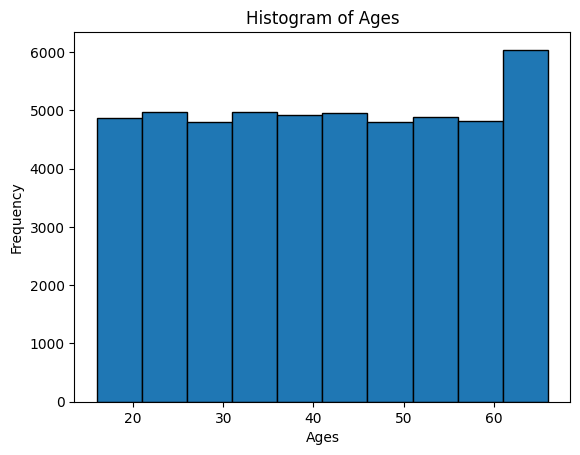

In [9]:
%pip install matplotlib

import matplotlib.pyplot as plt

users_df = read_result["users"].to_pandas()

plt.hist(users_df['age'], bins=10, edgecolor='black')
plt.title('Histogram of Ages')
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.show()

## Working in SQL

Since data is cached in a local DuckDB database, we can query the data with SQL.

We can do this in multiple ways. One way is to use the [JupySQL Extension](https://jupysql.ploomber.io/en/latest/user-guide/template.html), which we'll use below.

In [10]:
# Install JupySQL to enable SQL cell magics
%pip install --quiet jupysql
# Load JupySQL extension
%load_ext sql
# Configure max row limit (optional)
%config SqlMagic.displaylimit = 200


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [11]:
# Get the SQLAlchemy 'engine' object for the cache
engine = read_result.cache.get_sql_engine()
# Pass the engine to JupySQL
%sql engine

In [12]:
# Get the table for the 'users' stream
users_table = read_result.cache.get_sql_table("users")
display(users_table.fullname)

/home/vscode/.local/lib/python3.10/site-packages/duckdb_engine/__init__.py:178: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


'main.users'

In [23]:
%%sql
# We can now dynamically pass the table reference into a SQL query

SELECT name, occupation, age, nationality 
FROM {{ users_table.fullname }}
LIMIT 20

Running query in 'duckdb:///.cache/default_cache_db.duckdb'

name,occupation,age,nationality
Murray,Reporter,36,Uruguayan
Danyell,Brewery Manager,63,Latvian
Shirleen,Recovery Vehicle Coordinator,46,Ecuadorian
Carroll,Tug Skipper,63,Bolivian
Osvaldo,Genealogist,63,Japanese
Cicely,Tattooist,59,Portuguese
Kyle,Park Attendant,65,Mexican
Shizue,Laundry Worker,24,Dominican
Travis,Technical Clerk,42,Argentinian
Joan,Aerobic Instructor,49,Japanese


In [24]:
# Show tables for the other streams
%sqlcmd tables

Name
products
purchases
users
_airbytelib_streams
